Training RNNs on ODR
====================



## Notebook Settings



In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

%run ../notebooks/setup.py
%matplotlib inline
%config InlineBackend.figure_format = 'png'

REPO_ROOT = "/home/leon/models/NeuroFlame"
pal = sns.color_palette("tab10")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python exe
/home/leon/mambaforge/envs/torch/bin/python

## Imports



In [1]:
import torch
  import torch.nn as nn
  import torch.optim as optim
  import torchmetrics
  import torch.nn.functional as F
  from torch.utils.data import Dataset, TensorDataset, DataLoader

In [1]:
import sys
  sys.path.insert(0, '../')

  import pandas as pd
  import torch.nn as nn
  from time import perf_counter
  from scipy.stats import circmean

  from src.network import Network
  from src.plot_utils import plot_con
  from src.decode import decode_bump, circcvl, decode_bump_torch
  from src.lr_utils import masked_normalize, clamp_tensor, normalize_tensor

## Helpers



### plots



In [1]:
def add_vlines(model, ax=None):

    if ax is None:
        for i in range(len(model.T_STIM_ON)):
            plt.axvspan(model.T_STIM_ON[i], model.T_STIM_OFF[i], alpha=0.25)
    else:
        for i in range(len(model.T_STIM_ON)):
            ax.axvspan(model.T_STIM_ON[i], model.T_STIM_OFF[i], alpha=0.25)

In [1]:
def plot_rates_selec(rates, idx=0, thresh=0.5, figname='fig.svg'):
        fig, ax = plt.subplots(1, 2, figsize=[2*width, height])
        r_max = thresh * np.max(rates[idx])

        idx = np.random.randint(0, 96*8)
        ax[0].imshow(rates[idx].T, aspect='auto', cmap='jet', vmin=0, vmax=r_max)
        ax[0].set_ylabel('Neuron #')
        ax[0].set_xlabel('Step')

        idx = np.random.randint(0, 96*8)
        ax[1].imshow(rates[idx].T, aspect='auto', cmap='jet', vmin=0, vmax=r_max)
        ax[1].set_ylabel('Neuron #')
        ax[1].set_xlabel('Step')
        # ax[1].set_ylim([745, 755])
        # plt.savefig(figname, dpi=300)
        plt.show()

In [1]:
def plot_m0_m1_phi(model, rates, idx, figname='fig.svg'):

      m0, m1, phi = decode_bump(rates, axis=-1)
      # m0, m1, phi = get_fourier_moments(rates, axis=-1)
      fig, ax = plt.subplots(1, 3, figsize=[2*width, height])

      xtime = np.linspace(0, model.DURATION, m0.shape[-1])
      idx = np.random.randint(0, 96*8, 16)
      print(idx)

      ax[0].plot(xtime, m0[idx].T)
      #ax[0].set_ylim([0, 360])
      #ax[0].set_yticks([0, 90, 180, 270, 360])
      ax[0].set_ylabel('$\mathcal{F}_0$ (Hz)')
      ax[0].set_xlabel('Time (s)')
      add_vlines(model, ax[0])

      ax[1].plot(xtime, m1[idx].T)
      # ax[1].set_ylim([0, 360])
      # ax[1].set_yticks([0, 90, 180, 270, 360])
      ax[1].set_ylabel('$\mathcal{F}_1$ (Hz)')
      ax[1].set_xlabel('Time (s)')
      add_vlines(model, ax[1])

      ax[2].plot(xtime, phi[idx].T * 180 / np.pi, alpha=.5)
      ax[2].set_ylim([0, 360])
      ax[2].set_yticks([0, 90, 180, 270, 360])
      ax[2].set_ylabel('Phase (°)')
      ax[2].set_xlabel('Time (s)')
      add_vlines(model, ax[2])

      plt.savefig(figname, dpi=300)
      plt.show()

### Data Split



In [1]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

  def split_data(X, Y, train_perc=0.8, batch_size=32, shuffle=True):

      # if shuffle:
      #     X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
      #                                                         train_size=train_perc,
      #                                                         stratify=Y[:, 0].cpu().numpy(),
      #                                                         shuffle=True)
      # else:
      X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                          train_size=train_perc,
                                                          stratify=None,
                                                          shuffle=False)

      plt.hist(Y_train[Y_train!=-999].cpu() * 180 / np.pi, bins=15, label='train')
      plt.hist(Y_test[Y_test!=-999].cpu() * 180 / np.pi, bins=15, label='test')
      plt.xlabel('Target Loc. (°)')
      plt.ylabel('Count')
      plt.show()

      print(X_train.shape, X_test.shape)
      print(Y_train.shape, Y_test.shape)

      train_dataset = TensorDataset(X_train, Y_train)
      val_dataset = TensorDataset(X_test, Y_test)

      # Create data loaders
      train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=shuffle)
      val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

      return train_loader, val_loader

### Optimization



In [1]:
def training_step(dataloader, model, loss_fn, optimizer, penalty=None, lbd=0.001, clip_grad=0, zero_grad=0):
    device = torch.device(DEVICE if torch.cuda.is_available() else "cpu")

    model.train()
    total_loss = 0.0
    total_batches = len(dataloader)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()

        rates = model(X)
        loss = loss_fn(rates, y)

        # Initialize reg_loss as a scalar tensor
        reg_loss = torch.tensor(0.0, device=device)

        # Only apply the penalty once per step
        if penalty is not None:
            for param in model.parameters():
                if penalty == 'l1':
                    reg_loss += torch.sum(torch.abs(param))
                elif penalty == 'l2':
                    reg_loss += torch.sum(param ** 2)  # Better to use param ** 2

            loss = loss + lbd * reg_loss

        # Backpropagation
        loss.backward()

        # Clip gradients
        if clip_grad:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
            #torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)

        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / total_batches
    return avg_loss

In [1]:
def validation_step(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    device = torch.device(DEVICE if torch.cuda.is_available() else "cpu")

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            rates = model(X)
            batch_loss = loss_fn(rates, y)
            val_loss += batch_loss.item() * X.size(0)

    val_loss /= size
    return val_loss

In [1]:
def optimization(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=100, penalty=None, lbd=1, thresh=0.005, zero_grad=0, gamma=0.9):

    # Choose one scheduler
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1, verbose=True)
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    device = torch.device(DEVICE if torch.cuda.is_available() else 'cpu')
    model.to(device)

    loss_list = []
    val_loss_list = []

    for epoch in range(num_epochs):
        loss = training_step(train_loader, model, loss_fn, optimizer, penalty, lbd, zero_grad=zero_grad)
        val_loss = validation_step(val_loader, model, loss_fn)

        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)
        else:
            scheduler.step()

        loss_list.append(loss)
        val_loss_list.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}')

        if val_loss < thresh and loss < thresh:
            print(f'Stopping training as loss has fallen below the threshold: {loss}, {val_loss}')
            break

        if val_loss > 300:
            print(f'Stopping training as loss is too high: {val_loss}')
            break

        if torch.isnan(torch.tensor(loss)):
            print(f'Stopping training as loss is NaN.')
            break

    return loss_list, val_loss_list

### Loss



In [1]:
import torch

def skewed_gaussian_loss(theta_batch, y_pred, theta_bias, sigma=30, alpha=1.0):
    """
    Asymmetric likelihood loss with skew controlled by alpha.
    - theta_batch: True stimulus angles (batch_size)
    - y_pred: Network predictions (batch_size)
    - sigma: Base noise level (degrees)
    - alpha: Skew magnitude/direction (alpha > 0: skew away from theta_bias)
    """
    # Compute angular difference (handling circularity)
    # delta = torch.remainder(theta_batch - theta_bias + torch.pi, 2.0 * torch.pi) - torch.pi
    delta = theta_batch - theta_bias
    delta = (delta + torch.pi) % (2 * torch.pi) - torch.pi

    # Determine skew direction: alpha should be positive if stimulus > theta_bias
    sign = torch.where(delta > 0, 1.0, -1.0)  # 1 if stimulus is clockwise from bias
    alpha_scaled = alpha * sign  # Skew direction depends on stimulus location

    # Skewed Gaussian likelihood
    delta = theta_batch - y_pred
    delta = (delta + torch.pi) % (2 * torch.pi) - torch.pi
    z = delta / sigma
    likelihood = torch.exp(-0.5 * z**2) * (1 + torch.erf(alpha_scaled * z / torch.sqrt(torch.tensor(2.0).to(y_pred.device))))

    # Negative log-likelihood loss
    loss = -torch.log(likelihood + 1e-6)
    return loss

In [1]:
def gaussian_loss(theta_batch, y_pred, sigma=30):
        # Likelihood term (stimulus fidelity)
        delta = y_pred - theta_batch
        delta = (delta + torch.pi) % (2 * torch.pi) - torch.pi
        likelihood = torch.exp(-0.5 * (delta / sigma)**2)

        return -torch.log(likelihood + 1e-6)

In [1]:
def polar_loss(theta_batch, y_pred):
        loss = nn.MSELoss(reduction='none')
        predicted_sin = torch.sin(y_pred)
        predicted_cos = torch.cos(y_pred)

        target_sin = torch.sin(theta_batch)
        target_cos = torch.cos(theta_batch)

        loss_sin = loss(predicted_sin, target_sin)
        loss_cos = loss(predicted_cos, target_cos)

        loss_angular = (loss_sin + loss_cos)

        return loss_angular

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AngularErrorLoss(nn.Module):
    def __init__(self, thresh=1, reg_tuning=0.1, class_weight='balanced', sigma_stimulus=30, alpha=0.1, prior=0, sigma_prior=60, reg_weight=1.0, reg_prior=0.5):
        super(AngularErrorLoss, self).__init__()
        self.loss = nn.MSELoss(reduction='none')
        # self.loss = nn.SmoothL1Loss(reduction='none')

        self.thresh = thresh
        self.reg_tuning = reg_tuning
        self.reg_weight = reg_weight
        self.class_weight = class_weight

        self.theta_bias = torch.tensor(prior * torch.pi / 180.0)
        self.sigma_prior = sigma * torch.pi / 180.0
        self.reg_prior = reg_prior

        self.alpha = alpha
        self.sigma_stimulus = sigma_stimulus * torch.pi / 180.0

    def forward(self, readout, theta_batch):
        m0, m1, y_pred = decode_bump_torch(readout, axis=-1)

        valid_mask = theta_batch != -999
        invalid_mask = ~valid_mask

        # angular loss (Dcos, Dsin)
        loss_polar = polar_loss(theta_batch, y_pred) * valid_mask

        # # adding weights to each target location
        # if self.class_weight=='balanced':
        #     # weights = self.compute_histogram_weights(theta_batch)
        #     weights = self.gaussian_weights(theta_batch)
        #     loss_polar *= self.reg_weight * weights
        loss_angular = loss_polar.sum()

        # bayesian inference
        # Treat θ_bias as a prior and force the network to integrate it with the stimulus.
        # theta_bias = self.theta_bias.to(y_pred.device)
        # loss_likelihood = skewed_gaussian_loss(theta_batch, y_pred, theta_bias,
        #                                        sigma=self.sigma_stimulus, alpha=self.alpha) * valid_mask

        # loss_prior = gaussian_loss(theta_bias, y_pred, sigma=self.sigma_prior) * valid_mask
        # loss_angular = loss_likelihood.sum() + self.reg_prior * loss_prior.sum()

        total_loss = loss_angular

        # adding bias towards/away from the reference
        # theta_bias = torch.tensor(self.reference + torch.pi).to(theta_batch.device)
        # loss_bias = self.polar_loss(theta_bias, y_pred) * valid_mask
        # total_loss += self.reg_bias * loss_bias.sum()

        # imposing tuning strength
        regularization = F.relu(self.thresh * m0 - m1) * valid_mask
        total_loss += self.reg_tuning * regularization.sum()

        # normalize over batch and time points
        total_loss /= valid_mask.sum()

        # imposing zero tuning in invalid mask
        loss_zero = self.loss(m1, 0.0 * m1) * invalid_mask
        total_loss += self.reg_tuning * (loss_zero.sum() / invalid_mask.sum())

        return total_loss

### Other



In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def continuous_bimodal_phases(N_BATCH, preferred_angle, sigma):
    # Sample half from preferred_angle and half from preferred_angle + 180
    half_batch = N_BATCH // 2

    # Sample from preferred_angle
    samples_1 = torch.normal(mean=preferred_angle, std=sigma, size=(half_batch, 1))

    # Sample from preferred_angle + 180
    samples_2 = torch.normal(mean=(preferred_angle + 180) % 360, std=sigma, size=(N_BATCH - half_batch, 1))

    # Combine samples and wrap around 360
    phase_samples = torch.cat((samples_1, samples_2), dim=0) % 360

    return phase_samples

# Example usage
# N_BATCH = 500
# preferred_angle = 45
# sigma = 45

# samples = continuous_bimodal_phases(N_BATCH, preferred_angle, sigma)

# plt.hist(samples.numpy(), bins='auto', density=True)
# plt.xlabel('Phase (degrees)')
# plt.ylabel('Probability Density')
# plt.title('Bimodal Distribution of Phases')
# plt.show()

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def continuous_biased_phases(N_BATCH, preferred_angle, sigma):
    phase_samples = torch.normal(mean=preferred_angle, std=sigma, size=(N_BATCH, 1))
    phase_samples = phase_samples % 360

    return phase_samples

In [1]:
import pickle as pkl

  def pkl_save(obj, name, path="."):
      pkl.dump(obj, open(path + "/" + name + ".pkl", "wb"))


  def pkl_load(name, path="."):
      return pkl.load(open(path + "/" + name + '.pkl', "rb"))

In [1]:
import torch
import numpy as np

def generate_weighted_phase_samples(N_BATCH, angles, preferred_angle, sigma):
    # Convert angles list to a tensor
    angles_tensor = torch.tensor(angles)

    # Calculate Gaussian probability distribution centered at preferred_angle
    probs = np.exp(-0.5 * ((angles - preferred_angle) / sigma) ** 2)
    probs /= probs.sum()  # Normalize to get probabilities

    # Create a categorical distribution from the computed probabilities
    distribution = torch.distributions.Categorical(torch.tensor(probs))

    # Sample from the distribution
    indices = distribution.sample((N_BATCH,))

    # Map indices to angles and reshape to (N_BATCH, 1)
    phase_samples = angles_tensor[indices].reshape(N_BATCH, 1)

    return phase_samples

In [1]:
def convert_seconds(seconds):
      h = seconds // 3600
      m = (seconds % 3600) // 60
      s = seconds % 60
      return h, m, s

## Model



In [1]:
REPO_ROOT = "/home/leon/models/NeuroFlame"
conf_name = "train_odr_EI.yml"
DEVICE = 'cuda:0'

IF_BIASED_PHASES = 0
IF_BIAS = 0

IF_RAND_REF = 0
reference = 90
sigma = 60

print('reference', reference, 'sigma', sigma)

if IF_BIASED_PHASES:
    class_weight = 'balanced'
else:
    class_weight = None

batch_size = 128
N_BATCH = int(batch_size * 7)
print('N_BATCH', N_BATCH, 'batch_size', batch_size)

seed = np.random.randint(0, 1e6)
seed = 1
print('seed', seed)

reference 90 sigma 60
N_BATCH 896 batch_size 128
seed 1

In [1]:
model = Network(conf_name, REPO_ROOT, VERBOSE=0, DEVICE=DEVICE, SEED=seed, N_BATCH=N_BATCH)

if IF_BIAS:
    if IF_RAND_REF:
        reference = np.random.randint(0, 360)
        model_state_dict = torch.load('models/odr/odr_bias_rand_ref_%d.pth' % seed)
        print('rand_ref')
    elif IF_BIASED_PHASES:
        print('fixed ref')
        model_state_dict = torch.load('models/odr/odr_%d.pth' % seed)
    model.load_state_dict(model_state_dict)

torch.Size([896])


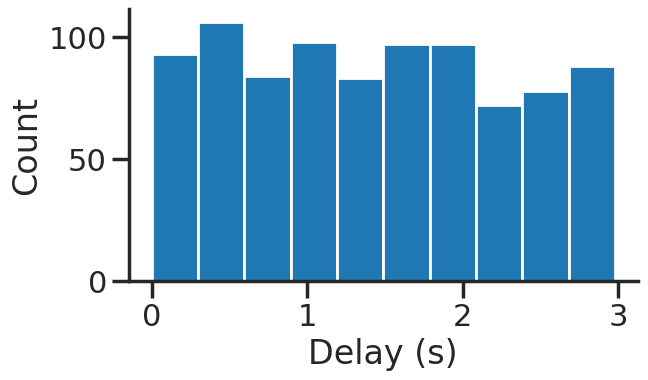

In [1]:
print(model.random_shifts.shape)
plt.hist(model.random_shifts.cpu().numpy() * model.DT)
plt.xlabel('Delay (s)')
plt.ylabel('Count')
plt.show()

## Training



In [1]:
model.J_STP.requires_grad = True

if IF_BIAS:
    model.J_STP.requires_grad = False

if IF_RAND_REF:
    reference = np.random.randint(0, 360)

#### Parameters



In [1]:
for name, param in model.named_parameters():
      if param.requires_grad:
          print(name, param.shape)

Wab_train torch.Size([750, 750])
J_STP torch.Size([])

In [1]:
model.N_BATCH = N_BATCH
rwd_mask = torch.zeros((model.N_BATCH, int((model.N_STEPS-model.N_STEADY) / model.N_WINDOW)), device=DEVICE, dtype=torch.bool)
print('rwd_mask', rwd_mask.shape)

for i in range(model.N_BATCH):
    # from first stim onset to second stim onset
    mask = torch.arange((model.start_indices[0, i] - model.N_STEADY)/ model.N_WINDOW,
                        (model.start_indices[1, i] - model.N_STEADY) / model.N_WINDOW).to(torch.int)
    # print(mask)
    rwd_mask[i, mask] = True

idx = np.random.randint(N_BATCH)
print(torch.where(rwd_mask[idx]==1)[0])

# rwd_mask = rwd_mask.repeat(N_TARGETS, 1)
# print('rwd_mask', rwd_mask.shape)
# print(torch.where(rwd_mask[idx+32]==1)[0])

rwd_mask torch.Size([896, 81])
tensor([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
        28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41],
       device='cuda:0')

#### Inputs and Labels



In [1]:
total_batches = N_BATCH // batch_size

print('total_batches', N_BATCH // batch_size)

labels = []
for _ in range(total_batches):
    # Generate biased data for each batch
    if IF_BIASED_PHASES:
        batch_labels = continuous_biased_phases(batch_size, reference, sigma)
        # batch_labels = continuous_bimodal_phases(batch_size, reference, sigma)
    else:
        batch_labels = torch.randint(0, 360, (batch_size, 1)).to(DEVICE)
    labels.append(batch_labels)

# Concatenate all batch labels into a single tensor
labels = torch.cat(labels, dim=0)
print(labels.shape)

total_batches 7
torch.Size([896, 1])

In [1]:
# if IF_BIASED_PHASES:
#          labels = continuous_biased_phases(N_BATCH, reference, sigma)
# else:
#          labels = torch.randint(0, 360, (N_BATCH, 1)).to(DEVICE)
# print(labels.shape)

In [1]:
model.PHI0 = torch.ones((N_BATCH, 2, 1), device=DEVICE, dtype=torch.float)
model.PHI0[:, 0] = labels * np.pi / 180.0

window_size = int((model.N_STEPS-model.N_STEADY) / model.N_WINDOW)
labels = labels.repeat(1, window_size) * np.pi / 180.0
labels[~rwd_mask] = -999

ff_input = model.init_ff_input()
print(model.PHI0.shape, ff_input.shape, labels.shape)

torch.Size([1, 750]) torch.Size([896, 1])
torch.Size([1, 750]) torch.Size([896, 1])
torch.Size([896, 2, 1]) torch.Size([896, 505, 1000]) torch.Size([896, 81])

In [1]:
# N_BATCH = 32
# N_SESSION = 8
# model.N_BATCH = N_BATCH
# print(model.N_BATCH)
# ff_input = []
# labels = []

# model.PHI0 = torch.ones((N_BATCH, 2, 1), device=DEVICE, dtype=torch.float)
# window_size = int((model.N_STEPS-model.N_STEADY) / model.N_WINDOW)

# for i in range(N_SESSION):
#         reference = torch.randint(low=0, high=360, size=(1,), device=DEVICE, dtype=torch.float)
#         label = continuous_biased_phases(N_BATCH, reference[0], sigma)
#         model.PHI0[:, 0] = label * np.pi / 180.0

#         label = label.repeat(1, window_size) * np.pi / 180.0
#         label[~rwd_mask[:32]] = -999
#         labels.append(label)

#         ff_input.append(model.init_ff_input())

# labels = torch.vstack(labels)
# ff_input = torch.vstack(ff_input)
# print('ff_input', ff_input.shape, 'labels', labels.shape)

torch.Size([40146])


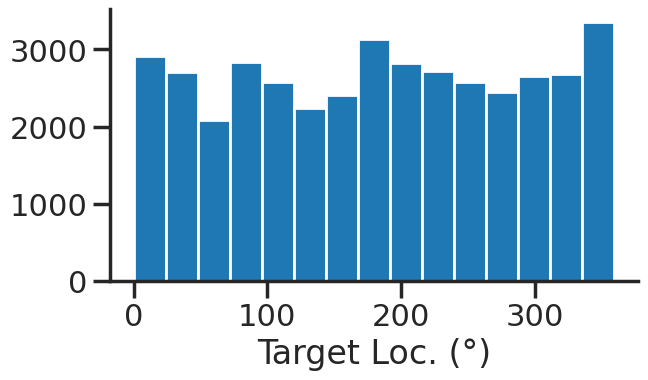

In [1]:
print(labels[labels!=-999].shape)
plt.hist(labels[labels!=-999].cpu() * 180 / np.pi, bins=15)
plt.xlabel('Target Loc. (°)')
plt.show()

#### Run




torch.Size([716, 505, 1000]) torch.Size([180, 505, 1000])
torch.Size([716, 81]) torch.Size([180, 81])

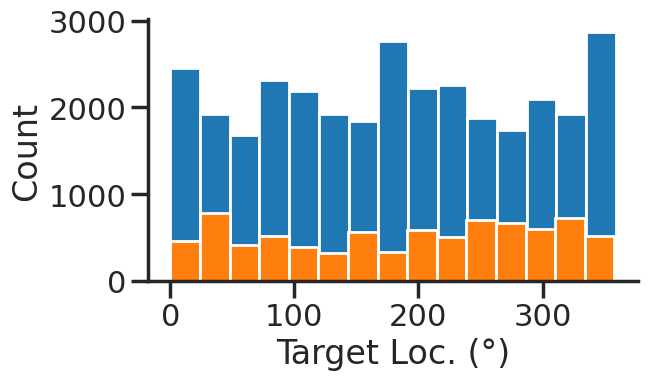

In [1]:
train_loader, val_loader = split_data(ff_input, labels, train_perc=0.8, batch_size=batch_size, shuffle=False)

In [1]:
if IF_BIAS:
    criterion = AngularErrorLoss(thresh=0.75, class_weight=None, prior=reference, sigma_prior=60, sigma_stimulus=30, alpha=0.0, reg_prior=0.0)
else:
    criterion = AngularErrorLoss(thresh=0.75, class_weight=None, prior=reference, sigma_prior=30, sigma_stimulus=15, alpha=0.0, reg_prior=0.0)

learning_rate = 0.1
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [1]:
num_epochs = 15
  start = perf_counter()
  loss = optimization(model, train_loader, val_loader, criterion, optimizer, num_epochs, thresh=.005)
  end = perf_counter()
  print("Elapsed (with compilation) = %dh %dm %ds" % convert_seconds(end - start))

#+begin_example
Epoch 1/15, Training Loss: 1.4675, Validation Loss: 1.4143
Epoch 2/15, Training Loss: 1.2684, Validation Loss: 1.1846
Epoch 3/15, Training Loss: 0.9505, Validation Loss: 0.5019
Epoch 4/15, Training Loss: 0.1870, Validation Loss: 0.1096
Epoch 5/15, Training Loss: 0.0813, Validation Loss: 0.0957
Epoch 6/15, Training Loss: 0.0770, Validation Loss: 0.0797
Epoch 7/15, Training Loss: 0.0627, Validation Loss: 0.0662
Epoch 8/15, Training Loss: 0.0492, Validation Loss: 0.0518
Epoch 9/15, Training Loss: 0.0391, Validation Loss: 0.0425
Epoch 10/15, Training Loss: 0.0316, Validation Loss: 0.0350
Epoch 11/15, Training Loss: 0.0277, Validation Loss: 0.0310
Epoch 12/15, Training Loss: 0.0246, Validation Loss: 0.0269
Epoch 13/15, Training Loss: 0.0213, Validation Loss: 0.0243
Epoch 14/15, Training Loss: 0.0194, Validation Loss: 0.0221
Epoch 15/15, Training Loss: 0.0174, Validation Loss: 0.0208
Elapsed (with compilation) = 0h 1m 20s
#+end_example

In [1]:
if IF_BIASED_PHASES:
    if IF_RAND_REF:
        torch.save(model.state_dict(), 'models/odr/odr_bias_rand_ref_%d.pth' % seed)
    else:
        if class_weight == 'balanced':
            torch.save(model.state_dict(), 'models/odr/odr_bias_%d_ref_%d_bal_loss.pth' % (reference, seed) )
        else:
            torch.save(model.state_dict(), 'models/odr/odr_bias_%d_ref_%d.pth' % (reference, seed) )

else:
    torch.save(model.state_dict(), 'models/odr/odr_%d.pth' % seed)

## Testing



In [1]:
if IF_BIASED_PHASES:
    print('Biased ODR')
    if IF_RAND_REF:
        model_state_dict = torch.load('models/odr/odr_bias_rand_ref_%d.pth' % seed )
    else:
        if class_weight == 'balanced':
            model_state_dict = torch.load('models/odr/odr_bias_%d_ref_%d_bal_loss.pth' % (reference, seed) )
        else:
            model_state_dict = torch.load('models/odr/odr_bias_%d_ref_%d.pth' % (reference, seed) )
else:
    model_state_dict = torch.load('models/odr/odr_%d.pth' % seed)

model.load_state_dict(model_state_dict)
model.eval()

Network(
  (dropout): Dropout(p=0.0, inplace=False)
)

In [1]:
model.N_BATCH = N_BATCH
    if IF_BIAS:
        model.PHI0 = torch.zeros(size=(N_BATCH, 3, 1), device=DEVICE, dtype=torch.float)
        labels = continuous_biased_phases(N_BATCH, reference, sigma) * torch.pi / 180.0
        # labels = continuous_bimodal_phases(N_BATCH, reference, sigma) * torch.pi / 180.0
        model.PHI0[:, 0] = labels
    else:
        labels = torch.randint(0, 360, (N_BATCH, 1)).to(DEVICE) * torch.pi / 180.0
        model.PHI0 = torch.ones((N_BATCH, 2, 1), device=DEVICE, dtype=torch.float)
        model.PHI0[:, 0] = labels

    ff_input = model.init_ff_input()
    print(model.PHI0.shape, ff_input.shape, labels.shape)

torch.Size([1, 750]) torch.Size([896, 1])
torch.Size([1, 750]) torch.Size([896, 1])
torch.Size([896, 2, 1]) torch.Size([896, 505, 1000]) torch.Size([896, 1])

In [1]:
#     model.N_BATCH = N_BATCH
#     ff_input = []
#     labels = []

#     model.PHI0 = torch.ones((N_BATCH, 2, 1), device=DEVICE, dtype=torch.float)

#     for i in range(len(phase_list)):
#         model.PHI0[:, 0] = phase_list[i]
#         label = torch.ones(model.N_BATCH, device=DEVICE, dtype=torch.float) * phase_list[i] * torch.pi / 180.0

#         labels.append(label)
#         ff_input.append(model.init_ff_input())

#     labels = torch.hstack(labels)
#     ff_input = torch.vstack(ff_input)
#     print('ff_input', ff_input.shape, 'labels', labels.shape)

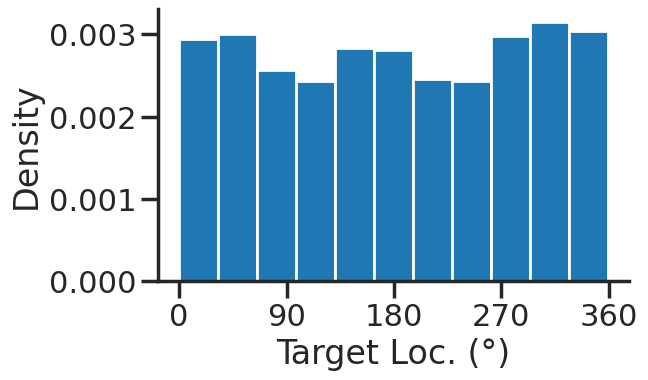

In [1]:
plt.hist(labels[:, 0].cpu() * 180 / np.pi, bins='auto', density=True)
plt.xlabel('Target Loc. (°)')
plt.ylabel('Density')
plt.xticks(np.linspace(0, 360, 5))
plt.savefig('./figs/memhist/targets.svg', dpi=300)
plt.show()

In [1]:
rates = model.forward(ff_input=ff_input).cpu().detach().numpy()
print('ff_input', ff_input.shape)
print('rates', rates.shape)

ff_input torch.Size([896, 505, 1000])
rates (896, 81, 750)

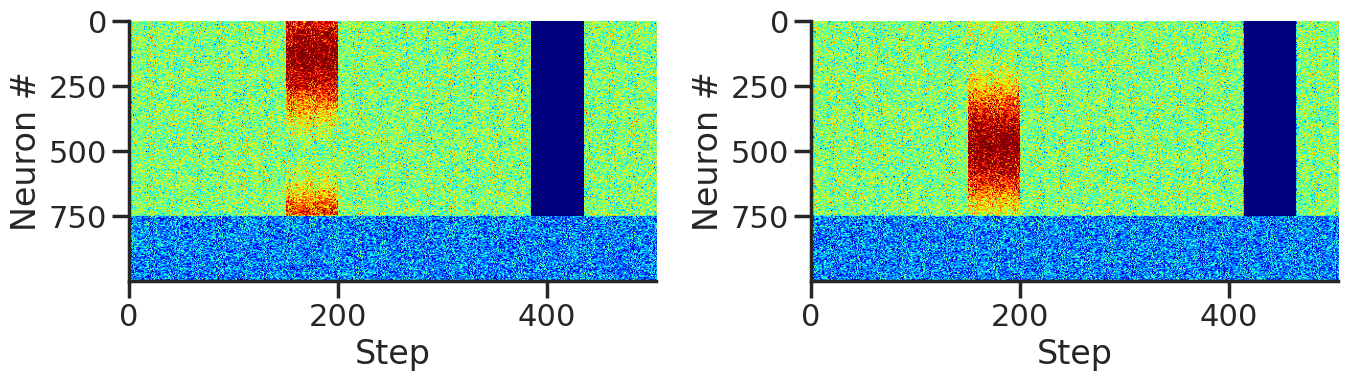

In [1]:
plot_rates_selec(rates=ff_input.cpu().detach().numpy(), idx=20, thresh=.5)

[535 146  38 243 417 374 737 448 344 716 201 212 657 156  36 561]


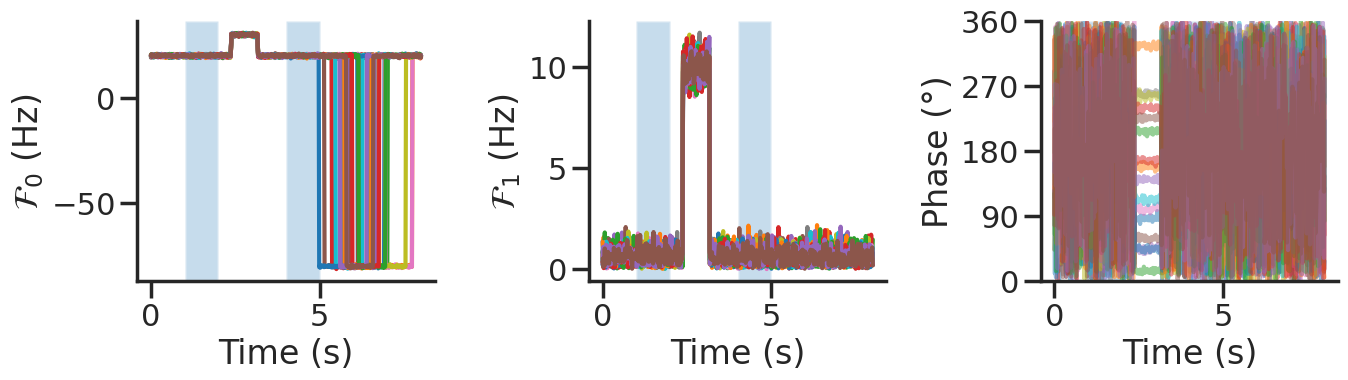

In [1]:
plot_m0_m1_phi(model, ff_input.cpu().numpy()[..., model.slices[0]], 10)

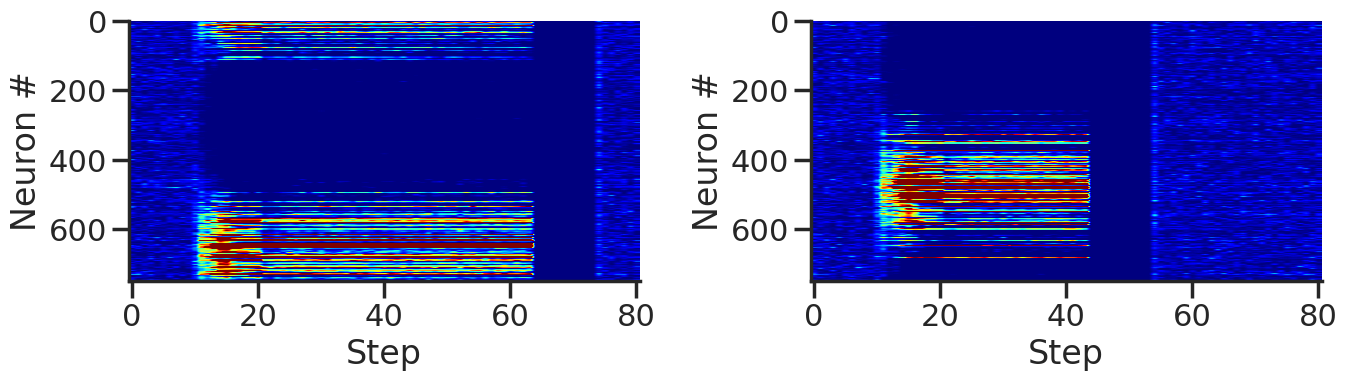

In [1]:
plot_rates_selec(rates, idx=20, thresh=.1)

[743  60 394 490 493 392 238 316 582 552 100 303 478 362 551   3]


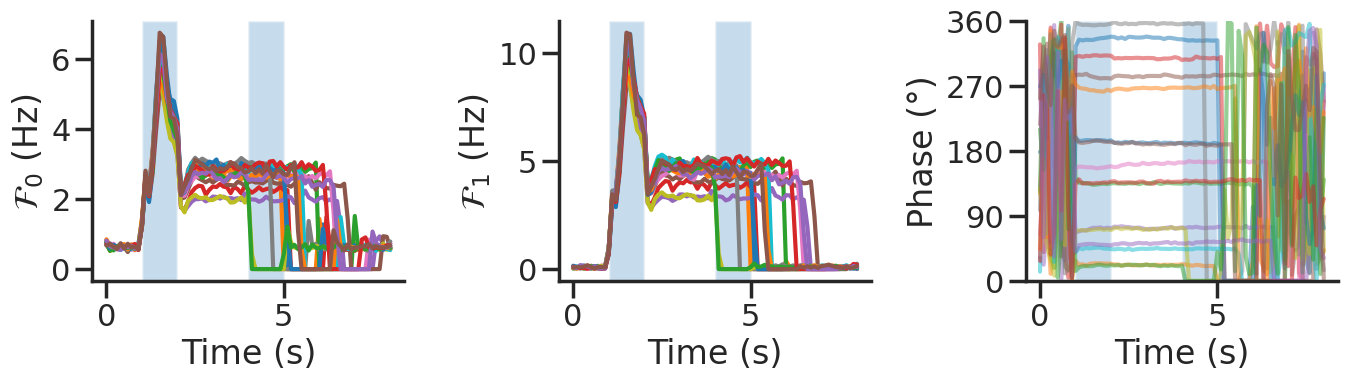

In [1]:
plot_m0_m1_phi(model, rates, 4)

In [1]:
m0, m1, phi = decode_bump(rates, axis=-1)
print(phi.shape, labels.shape)

target_loc = labels.cpu().numpy()
# print(target_loc.shape)

errors = (phi - target_loc)
errors = (errors + np.pi) % (2 * np.pi) - np.pi
errors *= 180 / np.pi

errors2 = errors[:, int((model.N_STIM_OFF[0].cpu().numpy()-model.N_STEADY) / model.N_WINDOW)]
# print(errors2.shape)

error_list = []
for i in range(errors.shape[0]):
    # idx_stim = model.start_indices[1, i%N_TARGETS].cpu().numpy()
    idx_stim = model.start_indices[1, i].cpu().numpy()
    idx = int((idx_stim - model.N_STEADY) / model.N_WINDOW)

    error_list.append(errors[i, idx])
# errors = errors[:, int((model.N_STIM_ON[1].cpu().numpy()-model.N_STEADY) / model.N_WINDOW)-1]
errors = np.array(error_list)
# print(errors.shape, errors2.shape, target_loc.shape)

(896, 81) torch.Size([896, 1])

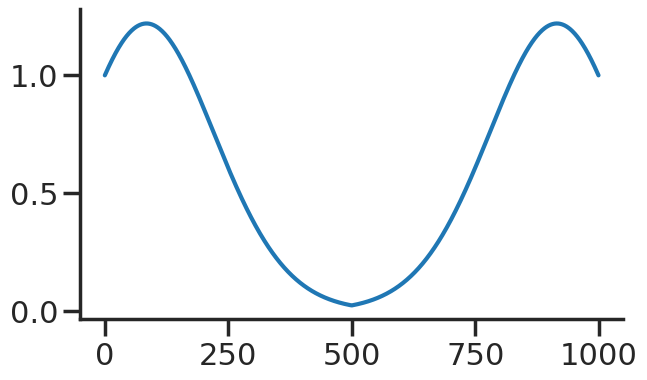

In [1]:
theta = torch.linspace(0, 2.0 * torch.pi, 1000)
loss = skewed_gaussian_loss(theta, torch.tensor(0), 0, sigma=60*torch.pi / 180, alpha=1.0)
# loss = gaussian_loss(theta, torch.tensor(0), sigma=60*torch.pi / 180)
plt.plot(np.exp(-loss.cpu().detach().numpy()));

In [1]:
if IF_BIAS:
    print('bias')
    pkl_save(phi, 'phase_bias', path="/home/leon/")
else:
    pkl_save(phi, 'phase', path="/home/leon/")

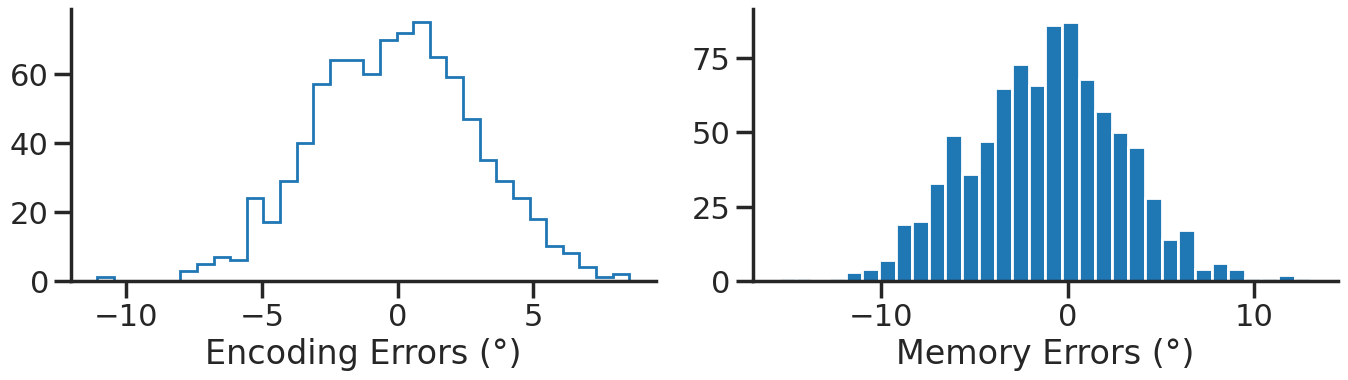

In [1]:
targets = (target_loc + np.pi) % (2 * np.pi) - np.pi

fig, ax = plt.subplots(1, 2, figsize=[2*width, height])
# ax[0].hist(targets[:, 0] * 180 / np.pi , bins=32 , histtype='step')
ax[0].hist(errors2, bins=32, histtype='step')
ax[0].set_xlabel('Encoding Errors (°)')

ax[1].hist(errors, bins=32)
ax[1].set_xlabel('Memory Errors (°)')
# ax[1].set_xlim([-45, 45])
plt.show()

## Connectivity



In [1]:
if IF_BIASED_PHASES:
    print('Biased ODR')
    if IF_RAND_REF:
        model_state_dict = torch.load('models/odr/odr_bias_rand_ref_%d.pth' % seed )
    elif class_weight == 'balanced':
        model_state_dict = torch.load('models/odr/odr_bias_%d_ref_%d_bal_loss.pth' % (reference, seed) )
    else:
        model_state_dict = torch.load('models/odr/odr_bias_%d_ref_%d.pth' % (reference, seed) )
else:
    print(seed)
    model_state_dict = torch.load('models/odr/odr_%d.pth' % seed)

model.load_state_dict(model_state_dict)
model.eval()

1
Network(
  (dropout): Dropout(p=0.0, inplace=False)
)

In [1]:
from src.lr_utils import LowRankWeights, clamp_tensor
Cij = model.GAIN * ( model.W_stp_T  + model.Wab_train[model.slices[0], model.slices[0]])
# Cij = model.Wab_train / model.Na[0] * model.J_STP
# Cij[Cij>0]= 1
Cij = clamp_tensor(Cij, 0, model.slices).cpu().detach().numpy()

if IF_BIAS==0:
    Cij0 = Cij
    pkl_save(Cij0, 'matrix', path=".")
    Kj0 = 0
    Ki0 = 0
else:
    Cij0 = pkl_load('matrix', path=".")
    Kj0 = pkl_load( 'Kj', path=".")
    Ki0 = pkl_load( 'Ki', path=".")

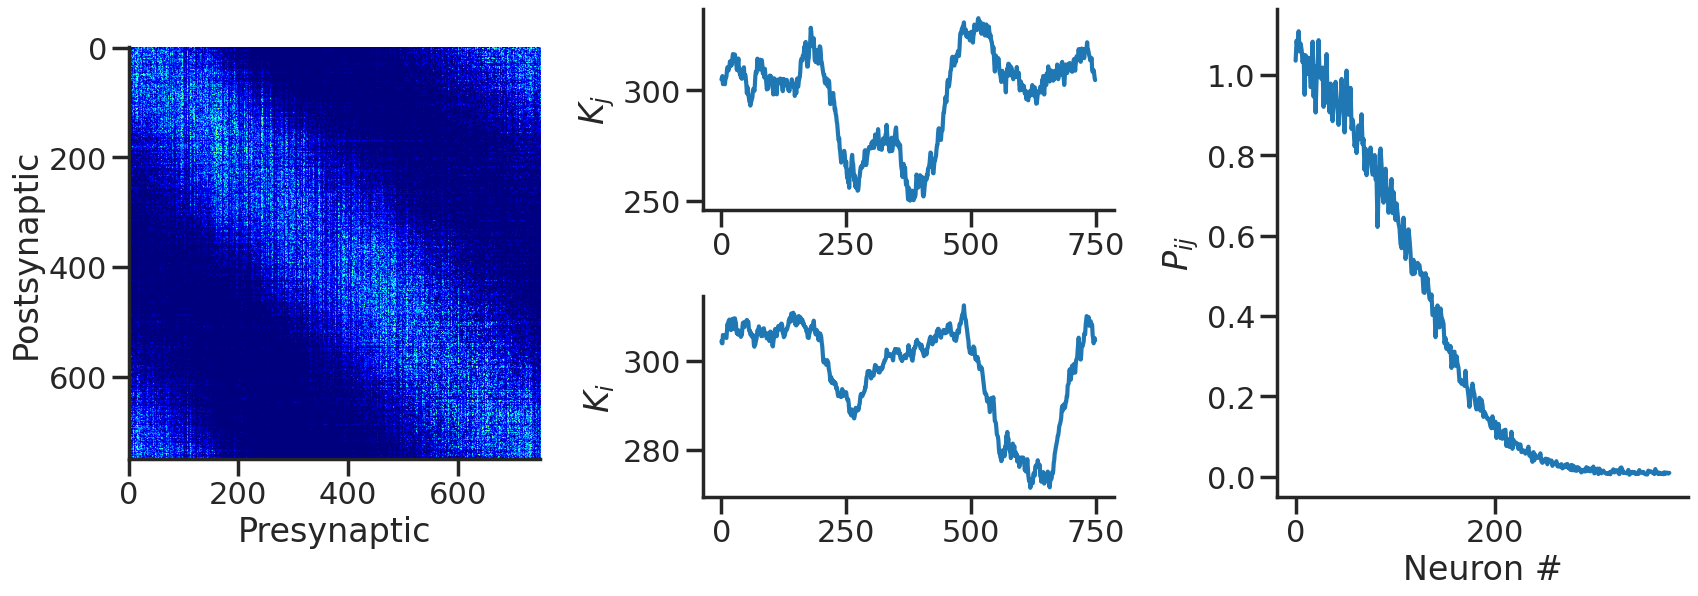

In [1]:
plt.figure(figsize=(2.5*width, 1.5*height))  # Set the figure size (width, height) in inches

  ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan=2)
  im = ax1.imshow(Cij, cmap='jet', aspect=1, vmin=0)
  ax1.set_xlabel("Presynaptic")
  ax1.set_ylabel("Postsynaptic")

  # Second column, first row
  ax2 = plt.subplot2grid((2, 3), (0, 1))
  Kj = np.sum(Cij, axis=0)  # sum over pres
  ax2.plot(circcvl(Kj-Kj0, windowSize=75))
  # ax2.set_xticklabels([])
  ax2.set_ylabel("$K_j$")

  # # Second column, second row
  ax3 = plt.subplot2grid((2, 3), (1, 1))
  Ki = np.sum(Cij, axis=1)  # sum over pres
  ax3.plot(circcvl(Ki-Ki0, windowSize=75))
  ax3.set_ylabel("$K_i$")

  ax4 = plt.subplot2grid((2, 3), (0, 2), rowspan=2)
  diags = []
  for i in range(int(Cij.shape[0] / 2)):
      diags.append(np.trace(Cij, offset=i) / Cij.shape[0])
  diags = np.array(diags)
  ax4.plot(diags)
  ax4.set_xlabel("Neuron #")
  ax4.set_ylabel("$P_{ij}$")

  plt.tight_layout()
  plt.show()

In [1]:
if IF_BIAS==0:
    pkl_save(Kj, 'Kj', path=".")
    pkl_save(Ki, 'Ki', path=".")

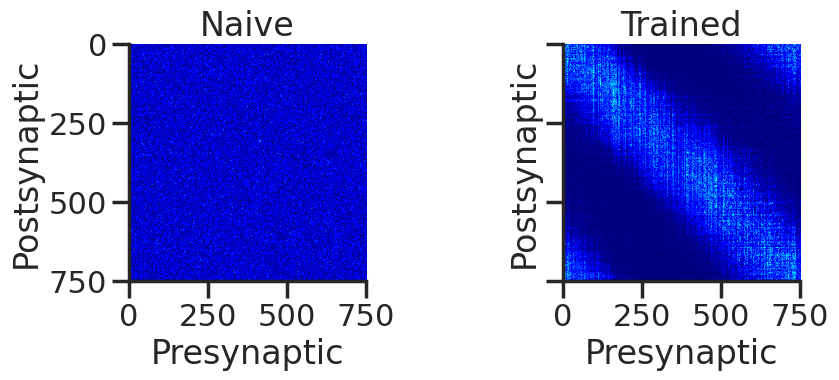

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height], sharey=1)

  Dij = Cij.flatten()
  np.random.shuffle(Dij)
  Dij = Dij.reshape(Cij.shape)

  im = ax[0].imshow(Dij, cmap='jet', aspect=1, vmin=0)
  ax[0].set_xlabel("Presynaptic")
  ax[0].set_ylabel("Postsynaptic")
  ax[0].set_title('Naive')
  ax[0].set_xticks(np.linspace(0, 750, 4))
  ax[0].set_yticks(np.linspace(0, 750, 4))

  im = ax[1].imshow(Cij, cmap='jet', aspect=1, vmin=0)
  ax[1].set_xlabel("Presynaptic")
  ax[1].set_ylabel("Postsynaptic")
  ax[1].set_title('Trained')
  ax[1].set_xticks(np.linspace(0, 750, 4))
  ax[1].set_yticks(np.linspace(0, 750, 4))

  plt.savefig('./figs/memhist/connectivity.svg', dpi=300)